# EMOTION DETECTION
### Detects the facial expression of the user and displays it.
Done by- Baibhav Saikia

### Importing the Necessary Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping

### Building the Model

In [2]:
base_model = MobileNet( input_shape=(224,224,3), include_top= False )
for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(units=7 , activation='softmax' )(x)
model = Model(base_model.input, x)

In [3]:
model.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

### Preparing the Data

In [4]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2, 
     shear_range = 0.2, 
     horizontal_flip=True, 
     rescale = 1./255
)
train_data = train_datagen.flow_from_directory(directory= "dataset/train", 
                                               target_size=(224,224), 
                                               batch_size=32,
                                  )
train_data.class_indices

Found 350 images belonging to 7 classes.


{'Angry': 0,
 'Disguist': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [5]:
val_datagen = ImageDataGenerator(rescale = 1./255 )
val_data = val_datagen.flow_from_directory(directory= "dataset/train", 
                                           target_size=(224,224), 
                                           batch_size=32,
                                  )

Found 350 images belonging to 7 classes.


### Visualising the Input Data

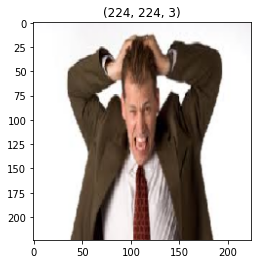

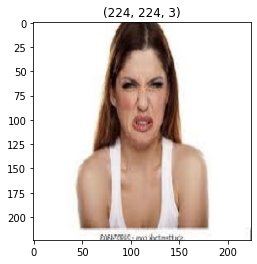

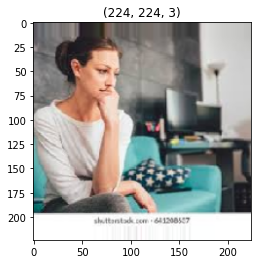

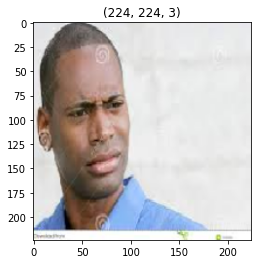

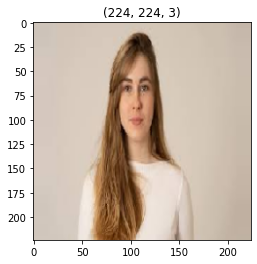

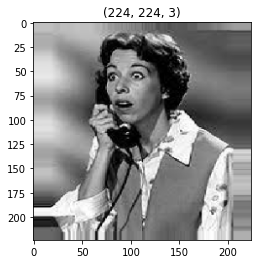

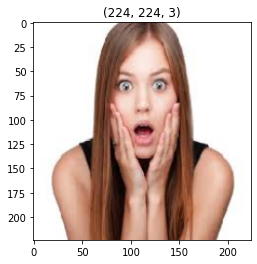

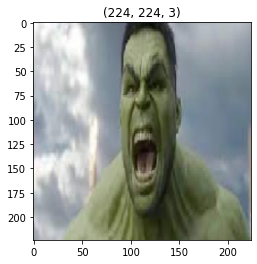

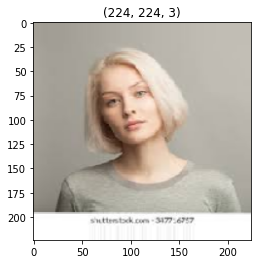

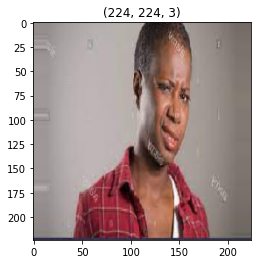

In [6]:
t_img , label = train_data.next()
def plotImages(img_arr, label):
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    
    count += 1
    if count == 10:
      break
    
plotImages(t_img, label)

### Training and Testing

In [7]:
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')
call_back = [es, mc]

In [8]:
hist = model.fit_generator(train_data, 
                           steps_per_epoch= 10, 
                           epochs= 30, 
                           validation_data= val_data, 
                           validation_steps= 8, 
                           callbacks=[es,mc])

C:\Users\asus\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
10/10 [==============================] - 50s 2s/step - loss: 12.4833 - accuracy: 0.1360 - val_loss: 5.8013 - val_accuracy: 0.4102

Epoch 00001: val_accuracy improved from -inf to 0.41016, saving model to best_model.h5
Epoch 2/30
10/10 [==============================] - 18s 2s/step - loss: 6.3109 - accuracy: 0.4268 - val_loss: 3.4070 - val_accuracy: 0.6250

Epoch 00002: val_accuracy improved from 0.41016 to 0.62500, saving model to best_model.h5
Epoch 3/30
10/10 [==============================] - 21s 2s/step - loss: 2.5733 - accuracy: 0.6943 - val_loss: 1.1956 - val_accuracy: 0.8477

Epoch 00003: val_accuracy improved from 0.62500 to 0.84766, saving model to best_model.h5
Epoch 4/30
10/10 [==============================] - 20s 2s/step - loss: 0.8139 - accuracy: 0.8228 - val_loss: 0.3006 - val_accuracy: 0.9258

Epoch 00004: val_accuracy improved from 0.84766 to 0.92578, saving model to best_model.h5
Epoch 5/30
10/10 [==============================] - 20s 2s/step - loss: 0.2795

### Loading the Best-Fit Model

In [9]:
model = load_model("best_model.h5")

In [10]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Plots

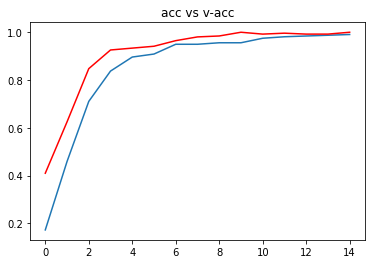

In [11]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

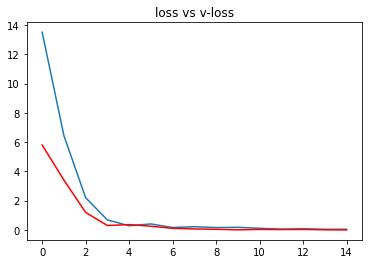

In [12]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [13]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))

### Reading from the Input Source

In [14]:
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)

while True:
    ret, test_img = cap.read() 
    if not ret:
        continue
    gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)

    for (x, y, w, h) in faces_detected:
        cv2.rectangle(test_img, (x, y), (x + w, y + h), (255, 0, 0), thickness=7)
        roi_gray = gray_img[y:y + w, x:x + h] 
        roi_gray = cv2.resize(roi_gray, (224, 224))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis=0)
        img_pixels /= 255
        predictions = model.predict(img_pixels)
        max_index = np.argmax(predictions[0])
        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]
        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ', resized_img)

    if cv2.waitKey(10) == ord('q'):  
        break

cap.release()
cv2.destroyAllWindows

KeyboardInterrupt: 

### Thank You